# Car prices prediction

## Intro

Our customer is a used car sales service that developes an application in order to attract new clients. The app helps to determine a market price of user's car.

Following criteria are essential for the customer:
* prediction quality
* time required for model trainig
* time required for prediction

**Objective** is to train a model with RMSE score under 2500

### Additional conditions
* use `LightBGM` library for gradient boosting
* use at least one non-GB model
* determine evaluation time for JupyterNB cells

### Dataset description

Dataset objects are entries crawled from car profile forms:

* `DateCrawled` — date the form was downloaded on from a database
* `VehicleType` — car body type
* `RegistrationYear` — year of car registration
* `Gearbox` — gearbox type
* `Power` — horsepower (hp)
* `Model` — car model
* `Kilometer` — car mileage (km)
* `RegistrationMonth` — month of car registration
* `FuelType` — fuel type
* `Brand` — car brand
* `Repaired` — was the car in repair or not
* `DateCreated` — car profile creation date
* `NumberOfPictures` — number of car photos
* `PostalCode` — postal code of a user who owns a car profile
* `LastSeen` — last user activity date

Target feature:
* `Price` — price (euro)

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We will use `ydata-profiling` library for EDA: https://github.com/ydataai/ydata-profiling.

In [2]:
from ydata_profiling import ProfileReport

### Globals

In [3]:
PATH_TO_DATA = './datasets/autos.csv' # path to dataset
RND = 1337 # randon state

## Open data and EDA

In [4]:
df = pd.read_csv(PATH_TO_DATA)
display(df.head(3), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


None

We will profile data using `ProfileReport` object

In [5]:
# ydata_profiling
profile = ProfileReport(df, title="Autos")

In [6]:
# we'll put report output in a different cell
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Let's check alerts the report provided us with

### Data preparation

#### Zeros

As the report says there are zeroes in `Price`, `Power` and `RegistrationMonth` columns. We will remove entries with `Price == 0` since thats our target data. Luckily, it's only 3% of data

In [7]:
# removing zeroes in Price
df = df[df['Price'] != 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        343597 non-null  object
 1   Price              343597 non-null  int64 
 2   VehicleType        309847 non-null  object
 3   RegistrationYear   343597 non-null  int64 
 4   Gearbox            326242 non-null  object
 5   Power              343597 non-null  int64 
 6   Model              326076 non-null  object
 7   Kilometer          343597 non-null  int64 
 8   RegistrationMonth  343597 non-null  int64 
 9   FuelType           314138 non-null  object
 10  Brand              343597 non-null  object
 11  Repaired           277731 non-null  object
 12  DateCreated        343597 non-null  object
 13  NumberOfPictures   343597 non-null  int64 
 14  PostalCode         343597 non-null  int64 
 15  LastSeen           343597 non-null  object
dtypes: int64(7), object(

`RegistrationMonth` column has zero values too, which is not good

In [8]:
# checking values for RegistrationMonth
df['RegistrationMonth'].value_counts().sort_index()

0     32881
1     22663
2     20814
3     33823
4     28701
5     28535
6     30847
7     26678
8     22134
9     23382
10    25610
11    23759
12    23770
Name: RegistrationMonth, dtype: int64

This **0** value might mean data on registration month was not provided. There are two options how to deal with it:
* Change **0** to **NaN** value to show data was not provided
* Remove the entire column from train data since this feature intuivly has less connection with `Price` than `RegistrationYear`
I will choose the second option for now. If metrics are bad I will bring it back.

In [9]:
# removing RegistrationMonth column
df = df.drop(columns = ['RegistrationMonth'])
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired',
       'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'],
      dtype='object')

Column `Power` has zeroes but this data is vital for target data and shows high correlation too. So we will assume `Power == 0` means data was not provided. We will change **0** to **NaN** for `Power`

In [10]:
# changing 0 to NaNs for Power
df['Power'] = df['Power'].where(df['Power'] != 0, other=np.NaN)

print('Checking number of zero values for "Power":', df.query('Power == 0')['Power'].count())
print('Checking number of missing values for "Power":', df['Power'].isna().sum())

Checking number of zero values for "Power": 0
Checking number of missing values for "Power": 36360


#### Constant

Column `NumberOfPictures` has constant value

In [11]:
df['NumberOfPictures'].unique()

array([0], dtype=int64)

This column bears no information so we will drop it

In [12]:
df = df.drop(columns=['NumberOfPictures'])
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired',
       'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

#### Duplicates

The dataset has some fully duplicated rows so we will drop them

In [13]:
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

#### High cardinality

Columns `DateCrawled`, `DateCreated`, `LastSeen` have no impact on target feature since they are not related to cars themselves but to database operation. We will drop those columns.

In [14]:
df = df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen'])
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired', 'PostalCode'],
      dtype='object')

Column `Model` is reported to have high cardinality too but this data could be important for target.

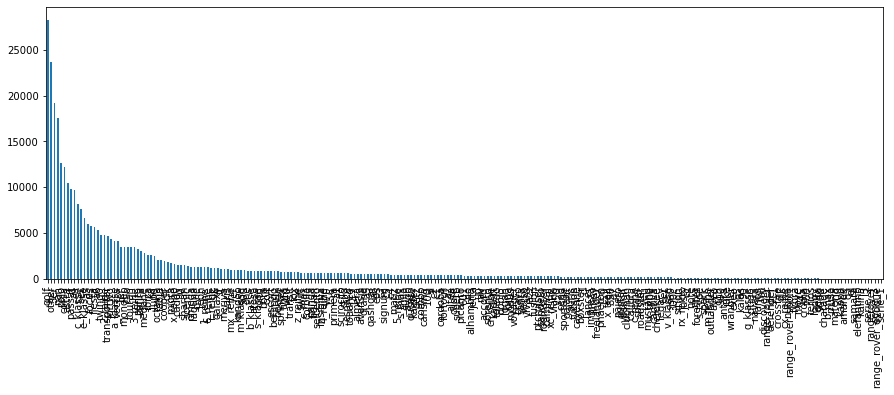

In [15]:
# checking value counts
model_counts = df['Model'].value_counts(dropna=False)
model_counts.plot(kind='bar', figsize=(15, 5))
plt.show()

In [16]:
display(model_counts.head(10), model_counts.tail(10))

golf        28246
other       23706
3er         19179
NaN         17521
polo        12628
corsa       12197
astra       10475
passat       9834
a4           9642
c_klasse     8174
Name: Model, dtype: int64

gl                    12
samara                12
elefantino            11
kalina                 9
i3                     8
serie_2                8
rangerover             4
serie_3                3
range_rover_evoque     2
serie_1                1
Name: Model, dtype: int64

We will check brand-model pairs

In [17]:
model_brand = df.groupby(by=['Brand', 'Model'], dropna=False)

In [18]:
model_brand[['Gearbox', 'Power', 'FuelType', 'VehicleType']].agg('nunique')

Gearbox  Power  FuelType  VehicleType
Brand      Model                                          
alfa_romeo 145             1     13         1            4
           147             2     24         3            5
           156             2     35         3            5
           159             2     17         2            2
           other           2     66         3            6
...                      ...    ...       ...          ...
volvo      v50             2     14         4            2
           v60             2     12         3            2
           v70             2     48         4            2
           xc_reihe        2     24         3            3
           NaN             2     27         4            3

[337 rows x 4 columns]

In [19]:
df[(df['Brand'] == 'alfa_romeo') & (df['Model'] == '145')].value_counts(subset='VehicleType', dropna=False)

VehicleType
small    19
sedan    12
NaN      12
coupe     2
other     1
dtype: int64

In [20]:
df['VehicleType'].value_counts(dropna=False)

sedan          89405
small          78017
wagon          63700
NaN            33750
bus            28345
convertible    19865
coupe          15634
suv            11791
other           3086
Name: VehicleType, dtype: int64

Although `Brand` and `Model` define a car there other features quite differ within one model: same models have different car body type, horsepower etc. Also there are models that are much more popular than others. We will put away our decision regarding this column for later. There are two options though:
* Introduce `other` category to models that are not widely present in dataset
* * Need to mention this category is already present here so this option might be the one I will choose
* Remove `Model` feature since it might not affect target too much

#### Second profile

We will redo dataset profiling after data manioulations we applied so far

In [21]:
# ydata_profiling
profile2 = ProfileReport(df, title="Autos2")

In [22]:
# we'll put report output in a different cell
profile2.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

#### High corellation

Having `Price` correlated with `RegistrationYear` and `Power` looks quite natural. Another problem is a full correlation between `RegistrationYear` and `VehicleType`. We will look closer at this columns

In [23]:
df['RegistrationYear'].value_counts()

2000    23072
1999    21994
2005    21524
2006    19679
2001    19653
        ...  
3800        1
4800        1
6500        1
2290        1
1946        1
Name: RegistrationYear, Length: 140, dtype: int64

In [24]:
df['VehicleType'].value_counts()

sedan          89405
small          78017
wagon          63700
bus            28345
convertible    19865
coupe          15634
suv            11791
other           3086
Name: VehicleType, dtype: int64

Column `VehicleType` has no problems but `RegistrationYear` has unrealistic values